####HW 3: Convolutional and Recurrent Neural Nets

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
import cv2
import re

Using TensorFlow backend.


In [2]:
# use tf 1.15.0 since 2.0.0 runs slowly on Colab
print(tf.__version__)

1.15.0


#### **Problem 1 (Convolutional Autoencoder).**

We build and fit a convolutional autoencoder for the Fashion MNIST dataset. Autoencoders learn to encode/compress data and decode/reconstruct the encoded representation to another representation that is as close to the original input as possible. Accordingly, one practical application of autoencoders is data compression.

The encoder will pass the data through a few convolutional layers, and the decoder will use `UpSampling2D` to get the representation back to the original size. We will also visualize input images together with their decoded reconstruction.

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


x_train shape: (60000, 28, 28) y_train shape: (60000,)
9


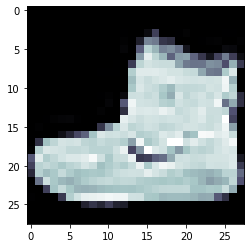

In [5]:
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
imshow(x_train[0], cmap='bone')
print(y_train[0])

In [0]:
x_train, x_test = x_train.reshape(x_train.shape[0], 28, 28, 1), x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [7]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


In [0]:
tfkl = tf.keras.layers

In [0]:
input_tensor = tfkl.Input(shape=(28, 28, 1))
conv_1 = tfkl.Conv2D(16, (3,3), padding='same', use_bias=False)(input_tensor)
pool_1 = tfkl.MaxPooling2D((2, 2), padding='same')(conv_1)
norm_1 = tfkl.BatchNormalization()(pool_1)
relu_1 = tfkl.Activation('relu')(norm_1)

conv_2 = tfkl.Conv2D(16, (3,3), padding='same', use_bias=False)(relu_1)
pool_2 = tfkl.MaxPooling2D((2, 2), padding='same')(conv_2)
norm_2 = tfkl.BatchNormalization()(pool_2)
relu_2 = tfkl.Activation('relu')(norm_2)

conv_2 = tfkl.Conv2D(4, (3,3), padding='same', use_bias=False)(relu_2)
pool_2 = tfkl.MaxPooling2D((2, 2), padding='same')(conv_2)
norm_2 = tfkl.BatchNormalization()(pool_2)
encoded = tfkl.Activation('relu')(norm_2)

conv_3 = tfkl.Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
samp_1 = tfkl.UpSampling2D((2, 2))(conv_3)

conv_3 = tfkl.Conv2D(8, (3, 3), activation='relu', padding='same')(samp_1)
samp_1 = tfkl.UpSampling2D((2, 2))(conv_3)
conv_4 = tfkl.Conv2D(16, (3, 3), activation='relu')(samp_1)
samp_2 = tfkl.UpSampling2D((2, 2))(conv_4)
decoded = tfkl.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(samp_2)

autoencoder = tf.keras.Model(input_tensor, decoded)
autoencoder.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_158 (Conv2D)          (None, 28, 28, 16)        144       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_69 (Batc (None, 14, 14, 16)        64        
_________________________________________________________________
activation_69 (Activation)   (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_159 (Conv2D)          (None, 14, 14, 16)        2304      
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 7, 7, 16)          0  

In [0]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
history = autoencoder.fit(x_train, x_train, epochs=10, batch_size=256)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 87s 1ms/sample - loss: 0.3975 - accuracy: 0.4903
Epoch 2/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.3238 - accuracy: 0.5005
Epoch 3/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.3128 - accuracy: 0.5025
Epoch 4/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.3079 - accuracy: 0.5033
Epoch 5/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.3048 - accuracy: 0.5039
Epoch 6/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.3027 - accuracy: 0.5042
Epoch 7/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.3008 - accuracy: 0.5045
Epoch 8/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.2993 - accuracy: 0.5047
Epoch 9/10
60000/60000 [==============================] - 86s 1ms/sample - loss: 0.2982 - accuracy: 0.5049
Epoch 10/10
60

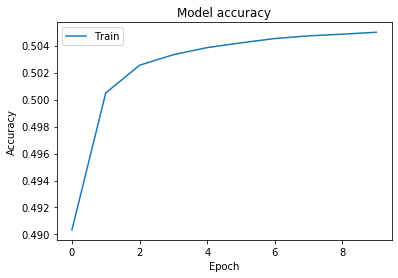

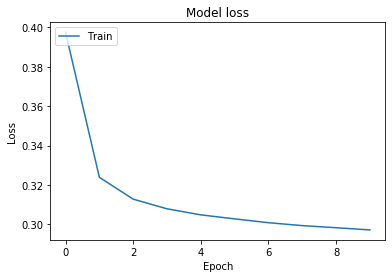

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

We visualize some digits reconstructed by the autoencoder.

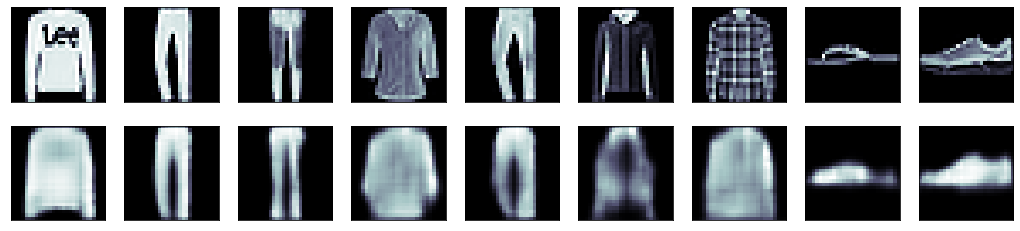

In [0]:
reconstructed = autoencoder.predict(x_test[:10])

plt.figure(figsize=(20, 4))
for i in range(1, 10):
    ax = plt.subplot(2, 10, i)
    plt.imshow(x_test[i].reshape(28, 28), cmap='bone')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, 10, i + 10)
    imshow(reconstructed[i].reshape(28, 28), cmap='bone')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


From the plots above, we can see that model accuracy rose to roughly 50% within the first epoch, and then remained there afterward.

The reconstructed digits produced by the autoencoder roughly resembe the original images. Properties like shape, some coloring, and curvature are represented in the reconstructed output. Essentially, the autoencoder's reconstructed images are outlines of the corresponding input data.

#### **Problem 2 (Image Classification).**

**2.1 (Deep CNN).** We build a deep CNN to classify images from the Fashion MNIST dataset.

In [8]:
input_tensor = tfkl.Input(shape=(28, 28, 1))
conv_1 = tfkl.Conv2D(32, (3, 3), activation='relu')(input_tensor)
maxpool_1 = tfkl.MaxPooling2D((2, 2))(conv_1)
conv_2 = tfkl.Conv2D(32, (3, 3), activation='relu')(maxpool_1)
flatten = tfkl.Flatten()(conv_2)
dense_1 = tfkl.Dense(8, activation='relu')(flatten)
output = tfkl.Dense(10, activation='softmax')(dense_1)

model = tf.keras.Model(inputs=input_tensor, outputs=output)

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
flatten (Flatten)            (None, 3872)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 30984     
______________________________________________

In [0]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 46s 766us/sample - loss: 0.6371 - acc: 0.7884 - val_loss: 0.4031 - val_acc: 0.8614
Epoch 2/5
60000/60000 [==============================] - 46s 759us/sample - loss: 0.3515 - acc: 0.8758 - val_loss: 0.3494 - val_acc: 0.8801
Epoch 3/5
60000/60000 [==============================] - 45s 743us/sample - loss: 0.3022 - acc: 0.8923 - val_loss: 0.3155 - val_acc: 0.8906
Epoch 4/5
60000/60000 [==============================] - 45s 743us/sample - loss: 0.2690 - acc: 0.9046 - val_loss: 0.3075 - val_acc: 0.8900
Epoch 5/5
60000/60000 [==============================] - 45s 746us/sample - loss: 0.2483 - acc: 0.9113 - val_loss: 0.3300 - val_acc: 0.8815


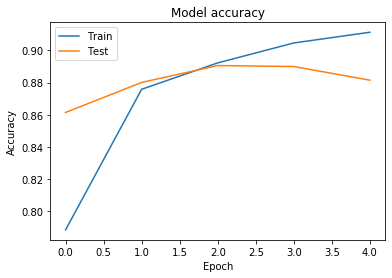

In [43]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

The CNN model begins with a convolutional layer using 32 filters, a 3x3 kernel, default striding of 1, and no padding (set to 'valid'). It feeds into a maxpooling layer with a (2, 2) pool (so each spatial dimension is reduced by half). This feeds into one more convolutional layer, followed by flattening for the dense classification layer.

The model obtains a final accuracy of 91.13 (train) / 88.15 (test). Overall, strong performance with some minor overfitting.

**2.2 (Transfer Learning).** This time, we use a pre-trained network. Except for the final Dense classification layer, all previous layers are held fixed.

In [50]:

(x_train_vgg, y_train_vgg), (x_test_vgg, y_test_vgg) = tf.keras.datasets.fashion_mnist.load_data()
x_train_vgg, x_test_vgg = x_train_vgg.reshape(x_train_vgg.shape[0], 28, 28, 1), x_test_vgg.reshape(x_test_vgg.shape[0], 28, 28, 1)

x_train_vgg = x_train_vgg.astype('float32') / 255
x_test_vgg = x_test_vgg.astype('float32') / 255
y_train_vgg = to_categorical(y_train_vgg, 10)
y_test_vgg = to_categorical(y_test_vgg, 10)

x_train_vgg = np.asarray([cv2.resize(i, (32,32)) for i in x_train_vgg])
x_test_vgg = np.asarray([cv2.resize(i, (32,32)) for i in x_test_vgg])

x_train_vgg = x_train_vgg.reshape(x_train_vgg.shape[0], 32, 32, 1)
x_test_vgg = x_test_vgg.reshape(x_test_vgg.shape[0], 32, 32, 1)

x_train_vgg = np.asarray([np.squeeze(np.stack((i, )*3, axis=-1)) for i in x_train_vgg])
x_test_vgg = np.asarray([np.squeeze(np.stack((i, )*3, axis=-1)) for i in x_test_vgg])

vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

flatten_1 = tfkl.Flatten()(vgg16_base.output)
dense_1 = tfkl.Dense(1024, activation='relu')(flatten_1)
outputs = tfkl.Dense(10, activation='sigmoid')(dense_1)

for layer in vgg16_base.layers:
    layer.trainable = False

vgg16_model = tf.keras.Model(vgg16_base.input, outputs)

vgg16_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [0]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

vgg16_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
print(x_train_vgg.shape)
print(x_test_vgg.shape)
print(y_train_vgg.shape)
print(y_test_vgg.shape)

(60000, 32, 32, 3)
(10000, 32, 32, 3)
(60000, 10)
(10000, 10)


In [53]:
history_vgg16 = vgg16_model.fit(x_train_vgg, y_train_vgg, validation_data=(x_test_vgg, y_test_vgg), batch_size=128, epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 718s 12ms/sample - loss: 0.5428 - acc: 0.8088 - val_loss: 0.4568 - val_acc: 0.8330
Epoch 2/5
60000/60000 [==============================] - 717s 12ms/sample - loss: 0.4036 - acc: 0.8519 - val_loss: 0.4156 - val_acc: 0.8515
Epoch 3/5
60000/60000 [==============================] - 715s 12ms/sample - loss: 0.3731 - acc: 0.8619 - val_loss: 0.3990 - val_acc: 0.8549
Epoch 4/5
60000/60000 [==============================] - 716s 12ms/sample - loss: 0.3451 - acc: 0.8734 - val_loss: 0.3818 - val_acc: 0.8623
Epoch 5/5
60000/60000 [==============================] - 716s 12ms/sample - loss: 0.3286 - acc: 0.8777 - val_loss: 0.3835 - val_acc: 0.8618


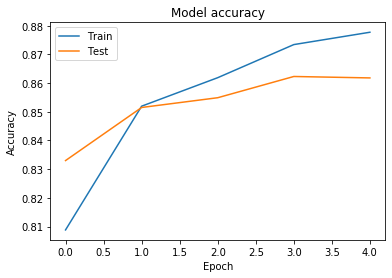

In [54]:
plt.plot(history_vgg16.history['acc'])
plt.plot(history_vgg16.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

With transfer learning, we obtain an accuracy of 87.77% (train) / 86.18% (test).

#### **Problem 3 (Text Classification).**

Building off of the idea that CNNs take advantage of local spatial correlations, we will take advantage of local temporal relations in natural language text.

**3.1 (RNN).** We build a RNN for text classification.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
!pwd
!ls '/content/drive/My Drive/data'

/content
column_labels.rtf  tweets_with_labels.csv


In [6]:
LABELS = {'k1': 'clouds', 'k2': 'cold', 'k3': 'dry',
          'k4': 'hot', 'k5': 'humid', 'k6': 'hurricane',
          'k7': "I can't tell", 'k8': 'ice', 'k9': 'other',
          'k10': 'rain', 'k11': 'snow', 'k12': 'storms',
          'k13': 'sun', 'k14': 'tornado', 'k15': 'wind'}

tweets_with_labels = pd.read_csv('/content/drive/My Drive/data/tweets_with_labels.csv', sep='\t')

tweets_with_labels.head()

,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
1,2,RT: @mention: I love rainy days.,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0
4,9,@mention good morning sunshine,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0


In [0]:
x, y = tweets_with_labels['tweet'], tweets_with_labels.drop(['tweet', 'id'], axis=1).values

In [8]:
x[0]

'Jazz for a Rainy Afternoon:  {link}'

In [9]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [0]:
df_labels = tweets_with_labels[['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9','k10', 'k11', 'k12', 'k13', 'k14', 'k15']]

In [0]:
def preprocessing(s):
  '''Retain alphabetic characters'''
    cleaned = re.sub('[^a-zA-Z]', ' ', s)
    cleaned = re.sub(r"\s+[a-zA-Z]\s+", ' ', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    return cleaned

In [0]:
x = [preprocessing(s) for s in list(tweets_with_labels["tweet"])]
y = df_labels.values

In [0]:
x_train_tweet, x_test_tweet, y_train_tweet, y_test_tweet = train_test_split(x, y, test_size=0.1)

In [0]:
tokens = Tokenizer(num_words=1000)

tokens.fit_on_texts(x_train_tweet)
tokens.texts_to_sequences(x_train_tweet)

x_train_tweet = tokens.texts_to_sequences(x_train_tweet)
x_test_tweet = tokens.texts_to_sequences(x_test_tweet)

vocab_size = len(tokens.word_index) + 1
max_features = 5000

max_seq_len = 64

x_train_tweet = pad_sequences(x_train_tweet, padding='post', maxlen=max_seq_len)
x_test_tweet = pad_sequences(x_test_tweet, padding='post', maxlen=max_seq_len)

In [22]:
print(x_train_tweet.shape, y_train_tweet.shape)
print(x_test_tweet.shape, y_test_tweet.shape)

(70151, 64) (70151, 15)
(7795, 64) (7795, 15)


In [27]:
inputs = tfkl.Input(shape=(64,))
embedding_1 = tfkl.Embedding(5000, 64)(inputs)
lstm_1 = tfkl.LSTM(64)(embedding_1)
outputs = tfkl.Dense(15, activation='sigmoid')(lstm_1)

lstm_model = tf.keras.Model(inputs=inputs, outputs=outputs)
lstm_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 64, 64)            320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 15)                975       
Total params: 353,999
Trainable params: 353,999
Non-trainable params: 0
_________________________________________________________________


In [0]:
lstm_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
lstm_history = lstm_model.fit(x_train_tweet, y_train_tweet, epochs=10, batch_size=256, 
                              validation_data=(x_test_tweet, y_test_tweet))

Train on 70151 samples, validate on 7795 samples
Epoch 1/10
70151/70151 [==============================] - 53s 755us/sample - loss: 1.3854 - acc: 0.7816 - val_loss: 1.4849 - val_acc: 0.7624
Epoch 2/10
70151/70151 [==============================] - 53s 749us/sample - loss: 1.3494 - acc: 0.7857 - val_loss: 1.5008 - val_acc: 0.7688
Epoch 3/10
70151/70151 [==============================] - 53s 750us/sample - loss: 1.3196 - acc: 0.7895 - val_loss: 1.3445 - val_acc: 0.7854
Epoch 4/10
70151/70151 [==============================] - 52s 742us/sample - loss: 1.2973 - acc: 0.7918 - val_loss: 1.3805 - val_acc: 0.7736
Epoch 5/10
70151/70151 [==============================] - 53s 754us/sample - loss: 1.2769 - acc: 0.7946 - val_loss: 1.8469 - val_acc: 0.6301
Epoch 6/10
70151/70151 [==============================] - 53s 750us/sample - loss: 1.2625 - acc: 0.7981 - val_loss: 1.3609 - val_acc: 0.7711
Epoch 7/10
70151/70151 [==============================] - 53s 761us/sample - loss: 1.2455 - acc: 0.8027 -

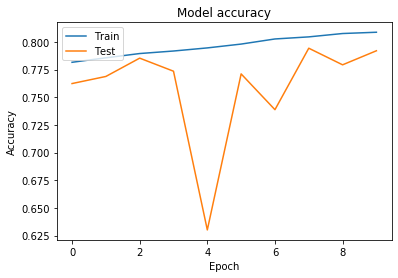

In [31]:
plt.plot(lstm_history.history['acc'])
plt.plot(lstm_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**3.2 (CNN).** We build a 1D CNN for text classification. We use a character-level convolution, using character embeddings.

In [32]:
inputs = tfkl.Input(shape=(64,))

embedding_1 = tfkl.Embedding(1000, 64)(inputs)
conv_1 = tfkl.Conv1D(64, 3, activation='relu')(embedding_1)
global_pool = tfkl.GlobalMaxPooling1D()(conv_1)
dense_1 = tfkl.Dense(32, activation='relu')(global_pool)
outputs = tfkl.Dense(15, activation='relu')(dense_1)

cnn_1D = tf.keras.Model(inputs=inputs, outputs=outputs)

cnn_1D.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 64, 64)            64000     
_________________________________________________________________
conv1d (Conv1D)              (None, 62, 64)            12352     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 15)                495       
Total params: 78,927
Trainable params: 78,927
Non-trainable params: 0
_______________________________________________________

In [0]:
cnn_1D.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
cnn_1D_history = cnn_1D.fit(x_train_tweet, y_train_tweet, epochs=10, batch_size=256,
                            validation_data=(x_test_tweet, y_test_tweet))

Train on 70151 samples, validate on 7795 samples
Epoch 1/10
70151/70151 [==============================] - 13s 187us/sample - loss: 2.7564 - acc: 0.6324 - val_loss: 2.5962 - val_acc: 0.7604
Epoch 2/10
70151/70151 [==============================] - 12s 174us/sample - loss: 2.3350 - acc: 0.7629 - val_loss: 2.3640 - val_acc: 0.7767
Epoch 3/10
70151/70151 [==============================] - 12s 170us/sample - loss: 2.2006 - acc: 0.7738 - val_loss: 2.1969 - val_acc: 0.7727
Epoch 4/10
70151/70151 [==============================] - 12s 174us/sample - loss: 2.1131 - acc: 0.7811 - val_loss: 2.1373 - val_acc: 0.7827
Epoch 5/10
70151/70151 [==============================] - 12s 171us/sample - loss: 2.0754 - acc: 0.7840 - val_loss: 2.1866 - val_acc: 0.7849
Epoch 6/10
70151/70151 [==============================] - 13s 179us/sample - loss: 2.0473 - acc: 0.7848 - val_loss: 2.1207 - val_acc: 0.7810
Epoch 7/10
70151/70151 [==============================] - 12s 173us/sample - loss: 2.0307 - acc: 0.7871 -

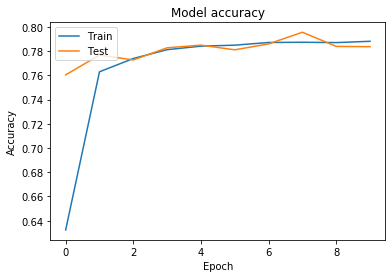

In [35]:
plt.plot(cnn_1D_history.history['acc'])
plt.plot(cnn_1D_history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**3.3 (Comparison).** We compare the RNN and CNN approaches.

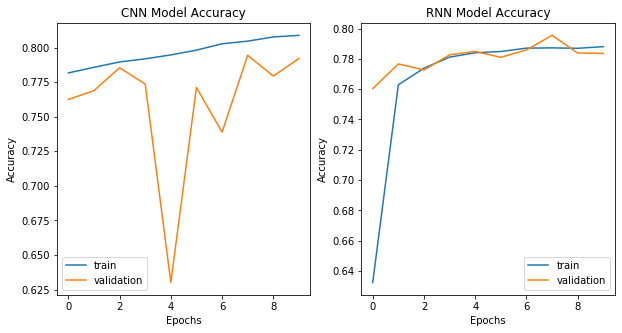

In [42]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['acc'])
plt.plot(lstm_history.history['val_acc'])
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])

plt.subplot(1, 2, 2)
plt.plot(cnn_1D_history.history['acc'])
plt.plot(cnn_1D_history.history['val_acc'])
plt.title('RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

The LSTM approach obtains accuracies of 80.88% (train) / 79.20% (test). The CNN approach obtains accuracies of 78.80% (train) / 78.36% (test). The LSTM, therefore, obtains slightly better results. However, note that the LSTM had over 350,000 parameters, whereas the CNN used fewer than 80,000.